# Risk Reports SNX

### Boilerplate Jupyter Notebook setup    

In [88]:
%cd C:\Dropbox\QUANTstudio\Python\sf_sprint
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import risk_compute_v2 as rr
import risk_reports_v2 as rp
import snx_debt_pool_composit_graph as snx

C:\Dropbox\QUANTStudio\Python\sf_sprint


In [89]:
debtPool, fund_holdings, fund_name, betas_table, betas3btc, betas3eth, table, stress, var_tables_presets, var_agg, var_tbl, \
    scenarios, leverage_ratios, lev_table, correlations = snx._main()

total synths Optimism = 5
total synths Mainnet  = 25
total wrappers Optimism = 3
total wrappers Mainnet  = 2
total loans Optimism = 43
total loans Mainnet  = 16
total rates Optimism = 12
total rates Mainnet  = 98
Ingesting portfolio holdings.
Ingesting fund historical returns.
Ingesting definition of historical scenarios.
Ingesting parametric stress testing factors.
Processing relevant token tickers.


# 
# Risk Report

## DebtPool Composition
Note: USDT represents small USD equivalent positions in ETHBTC, CHF, GBP, JPY and AUD

In [100]:
display(table.loc[(table.Quantity!=0)].drop(['MarginPair','Instrument'], axis=1).groupby(['Fund','Portfolio','Strategy','Usym']).sum().sort_values('Market Value', ascending=False).sort_index(level=1, sort_remaining=False).style.set_caption('Portfolio Holdings').set_properties(**{'text-align': 'right'}).format({'Quantity': "{:,.0f}", 'Price': '{:,.2f}', 'Market Value': '{:,.0f}'}))

### DebtPool Skew & Beta Equivalent Exposures

Skew is defined as a NET directional market exposure for SNX Staker resulting from DebtPool composition, which might not necesarily be market neutral.

Any asset or portfolio exposures can be represented in terms of volatility as compared with a benchmark. In finance, Beta is a measure of how an individual asset moves when the overall benchmark increases or decreases. Thus, beta is referred to as an asset's non-diversifiable risk, its systematic risk, market risk, or hedge ratio. Beta is not a measure of idiosyncratic risk. A beta of 1 means that the portfolio is neither more nor less volatile or risky than the wider market. 
A beta of more than 1 indicates greater volatility while a beta of less than 1 indicates less.

Tables below show overall portfolio totals in market value, Beta Equivalents to ETH and to SNX, both identified as proper benchmarks. 
As an example, in times of market duress, to hedge a net LONG portfolio's market risk, one would use most liquid assets and SELL the total Beta Equivalent quantity to immunize the portfolio from adverse price movements. 
It is worth noting that Beta is additive, thus a targetted hedging is possible to offset specific positions' risks.

In [91]:
rr.report_beta_exposures(betas_table, betas3btc, betas3eth, institutional=True)

Fund,MV USD,MV ETH,MV SNX,BetaEqETH,BetaEqSNX
Total,"1,075,097,430","357,527","204,119,504","419,196","200,241,335"


,MV USD,MV ETH,MV SNX,BetaEqETH,BetaEqSNX
Strategy,,,,,
synth,"1,466,172,076","487,580","278,369,485","532,558","228,148,742"
loan,"-2,470,943",-822,"-469,137",4,282
wrapper,"-388,603,704","-129,231","-73,780,844","-113,366","-27,907,689"


### Parametric Stress Tests

Parametric Stress Tests enable flexibility in terms of defining the shock factor(s) and observing the change in Market Value and ultimately resulting size of the DebtPool, given current market structure, correlations, volatilites and second order interdependencies.

The third stress down is defined as a two factor shock of **ETH down 10%, SNX down 10%** while **all other remaining assets proxied with Beta to ETH** to infer their impact. The cumulative impact on the portfolio is represented in **LOSS $** below. A table is also available in the Institutional View. 

Ticker,ETH,USDC,USDT,DPI,ADA,AAVE,DOT,EURT,LINK,LOSS $,FUND MV
Name,,,,,,,,,,,
ETH -0.1 [ETH],0.04,0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,"-126,054,025.33","949,043,404.18"
ETH -0.2 [ETH],0.08,0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,"-252,108,050.65","822,989,378.86"
ETH -0.1 SNX -0.1 [ETH],0.04,0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,"-90,763,385.94","984,334,043.57"
ETH -0.2 SNX -0.2 [ETH],0.08,0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,"-181,526,771.88","893,570,657.63"
ETH -0.3 SNX -0.3 [ETH],0.13,0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,"-272,290,157.81","802,807,271.70"
ETH 1 [ETH],-0.42,-0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.01,"1,260,540,253.26","2,335,637,682.77"
ETH @ $2000 [ETH],0.14,0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,"-422,147,512.72","652,949,916.79"
ETH @ $5000 [ETH],-0.28,-0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.01,"835,441,598.10","1,910,539,027.61"
ETH @ $10000 [ETH],-0.99,-0.00,-0.00,0.00,0.00,0.00,0.00,0.01,0.02,"2,931,423,449.46","4,006,520,878.97"


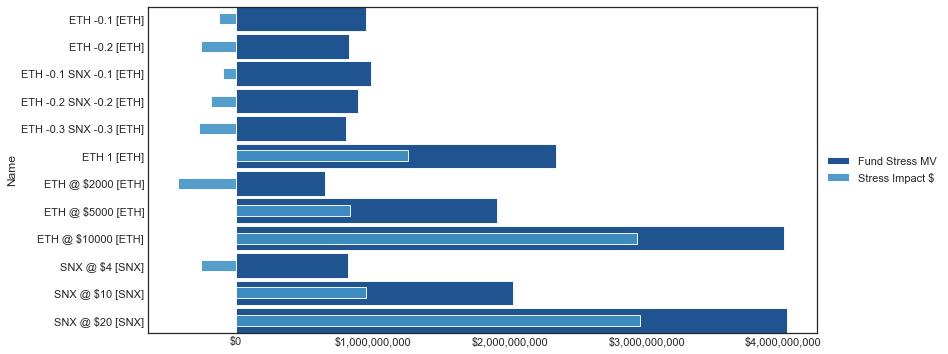

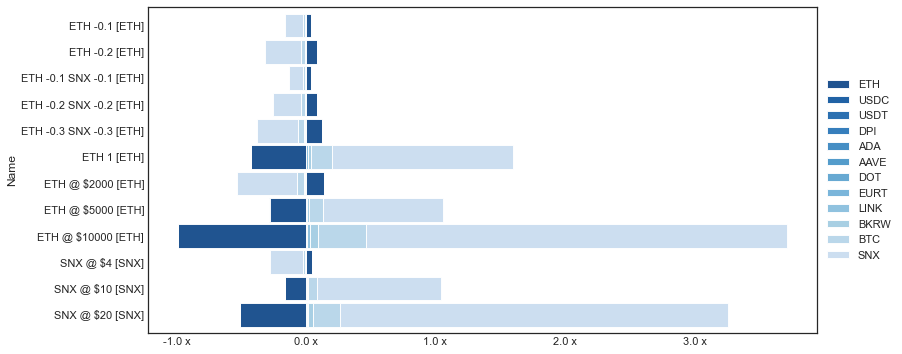

In [92]:
rr.report_stress_tests(stress, institutional=True)

### Value at Risk

VaR is widely used in the risk management industry to quantify the risk of an investment. It is a risk measure that attempts to quantify the level of market price risk within a portfolio. **1 Year 95% Confidence 1 Day VaR** quantifies a level of loss to be exppected and exceeded over a specific 1 day hold time frame given 1 year of historical observations and a 5% probability of occurance.

In the simplest historical variant, this approach calculates 365 daily historical PnLs for each holding using relevant time series. Then, it identifies the 5th percentile PnL (Loss) in the portfolio's composite PnL time series. 

The historical method for calculating VaR is not appropriate for returns distributions that are asymmetric, or display very fat tails (i.e. low-probability, high-impact returns, ... crypto). For this reason, this module implements more esoteric VaR methodologies:  
- Modified Value at Risk (**MVaR 95%**) calculation, which adjusts the standard deviation to account for skew and kurtosis in the returns distribution (greater negative skew and kurtosis act to increase VaR)
- Expected Shartfall (**ES_Modified 95%**) calculation, which extends the above approach via averaging the returns in the tail below the 5th percentile, resulting in an Expected Shortfall
- Modified Value at Risk (**MVaR 99%**) calculation at 1%, which is same as the MVaR above but looking deeper into the tail the 1st percentile.
- Lastly, the extreme worst historical day for the portfolio looking back 1 year

Above VaR measures are backward looking, typically generated for regulatory purposes and have failed many institutions during the Lehman collapse, since extreme liquidations events were not in the immediate history, extended the tail, leading to higher VaR, resulting in portfolio reductions due to limited risk budgets, leading to further selling and deeper tails, still higher VaR and further reductions, a negative feedback loop ultimataly resulting in a classic deleveraging. 

For completeness, it it highly recommended to inspect complementary Historical Scenarios and Parametric Stress Tests, included within.

,Modified,ES_Modified,Worst Case Historical
Total,10.9,13.8,28.9


,Modified,ES_Modified,Marginal_Component,Worst Case Historical
SNX,13.3,14.5,12.4,37.7
BTC,1.2,1.4,0.7,2.6
LINK,0.1,0.1,0.1,0.3
BKRW,0.2,0.2,0.1,0.5
USDC,0.0,0.0,-0.0,0.0
DPI,0.0,0.0,0.0,nan
USDT,0.0,0.0,0.0,0.0
ADA,0.0,0.0,0.0,0.0
AAVE,0.0,0.0,0.0,0.0
EURT,0.1,0.2,0.0,0.3


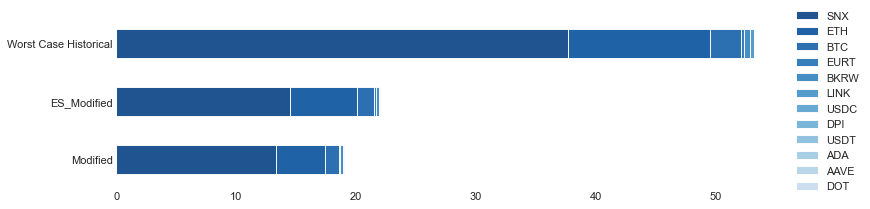

In [93]:
rr.report_var(var_tables_presets, var_agg, var_tbl, institutional=False)

### Historical Scenarios

Historical Scenarios are more revealing and complementary data points as compared to VaR results above, indicating current portfolio performance if endured through actual major market duress events identified in the past.  

In [94]:
rr.report_historical_scenarios(scenarios, institutional=False)

Scenario,Start Date,End Date,Days,Value Impact,Pct Impact
Post token generation weakness,2015-08-12,2015-10-20,69,"-1,030,206,502",-0.73
SEC postpones Bitcoin ETF,2018-05-04,2018-09-11,130,"-987,250,589",-0.70
Roubini - The Mother Of All Bubbles,2018-02-16,2018-04-05,48,"-951,385,547",-0.68
EOS ICO,2017-06-11,2017-07-15,34,"-911,558,326",-0.65
South Korea trading ban rumors,2018-01-12,2018-02-04,23,"-799,304,794",-0.57
The DAO hack,2016-06-15,2016-07-06,21,"-756,056,639",-0.54
DevCon 2 Shanghai DoS spam attack,2016-09-19,2016-12-04,76,"-722,927,268",-0.51
Homestead fork,2016-03-12,2016-04-27,46,"-714,423,472",-0.51
"PlanB model fail, hawkish Fed in Jan",2021-11-09,2022-01-23,75,"-680,401,897",-0.48
China bans ICOs,2017-08-31,2017-09-13,13,"-670,854,450",-0.48


### DebtPool Leverage Ratios
Definitions:   
  Leverage: - shorts / (shorts + longs)    
  Collaterization Ratio: -longs / shorts * 100

Leverage:                   0.48x
Loss to Liquidation:        -68%
Fund Gross/Net Ratio:       148%
Collaterization Ratio:      310%
Total Capital Borrowed:     $510,737,147


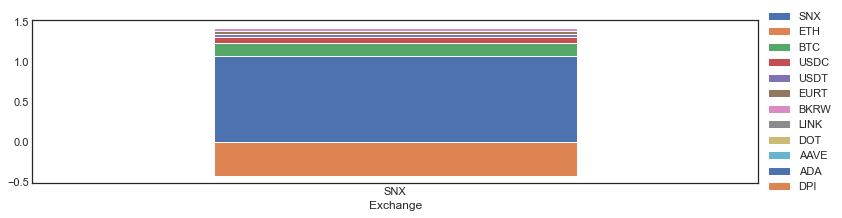

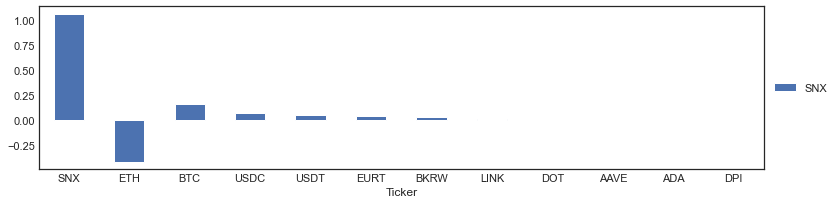

In [95]:
rr.report_leverage_ratios(leverage_ratios, lev_table, institutional=False)

### MainNet Leverage Ratios


Leverage:                   0.49x
Loss to Liquidation:        -67%
Fund Gross/Net Ratio:       149%
Collaterization Ratio:      305%
Total Capital Borrowed:     $457,978,801


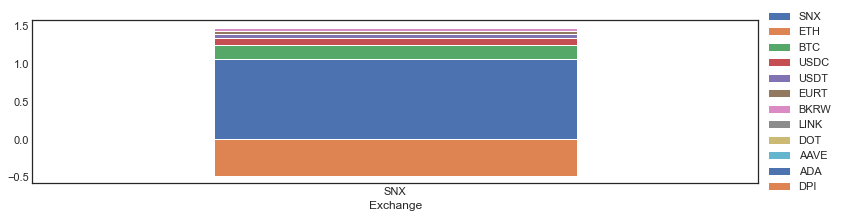

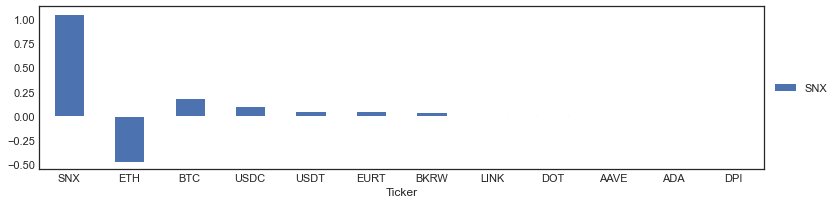

In [96]:
leverage_ratios, lev_table, cp_mv = rr.compute_leverage_ratios(table, fund_holdings[fund_holdings.Portfolio=='mainnet'])
rr.report_leverage_ratios(leverage_ratios, lev_table, institutional=False)

### Optimism Leverage Ratios


Leverage:                   0.38x
Loss to Liquidation:        -72%
Fund Gross/Net Ratio:       138%
Collaterization Ratio:      362%
Total Capital Borrowed:     $52,758,346


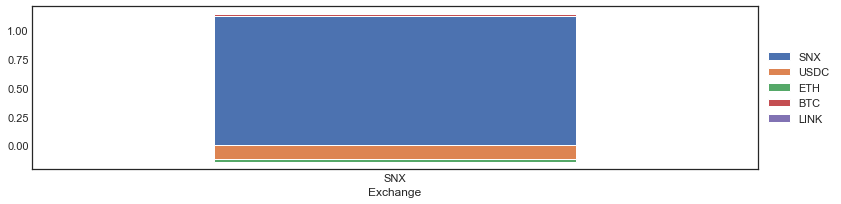

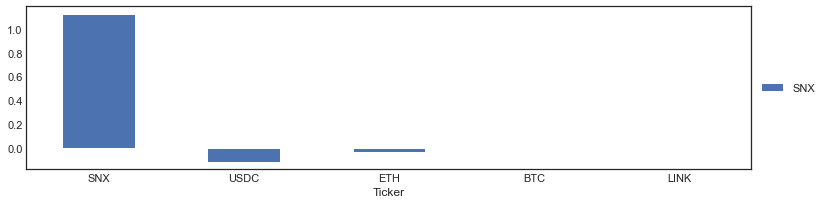

In [97]:
leverage_ratios, lev_table, cp_mv = rr.compute_leverage_ratios(table, fund_holdings[fund_holdings.Portfolio=='optimism'])
rr.report_leverage_ratios(leverage_ratios, lev_table, institutional=False)

### Portfolio Through Various Risk Lenses

Simple visualization to highlight any dominating assets in the portfolio using various risk measures, including portfolio allocations in terms of **Market Value USD**, **Beta to ETH**, token contribution to Value-at-Risk known as **Marginal VaR** (explained above), and a **Worst Case Historical Day** indicating impact of worst daily losses in the last 365 days for each asset on the overall portfolio.

[To Do: need to expose Short Positions, breakdown by asset Utility, by MCap]

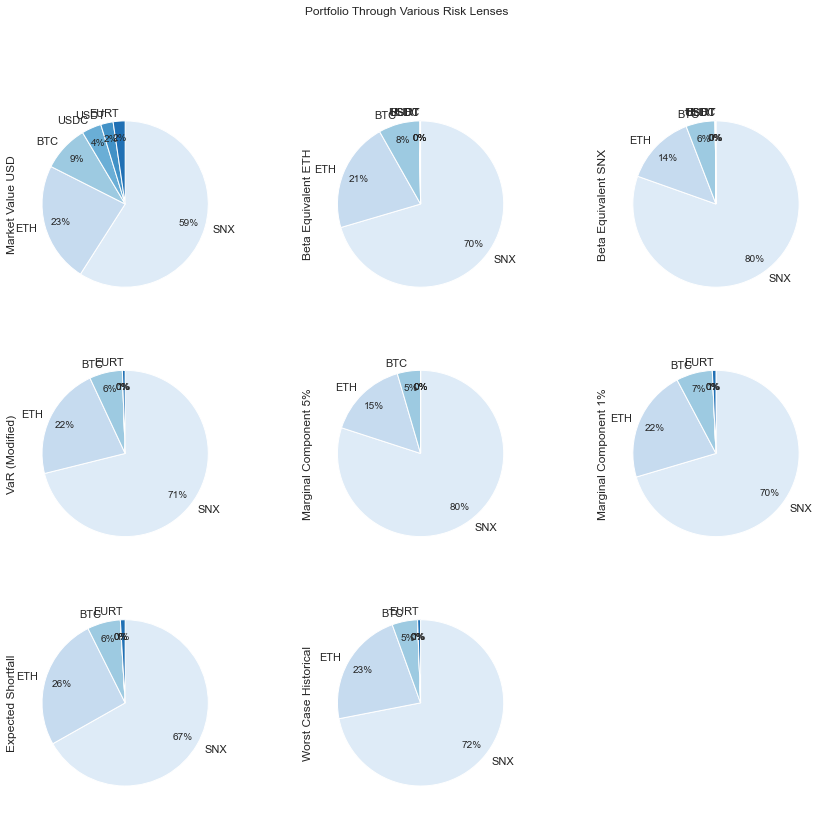

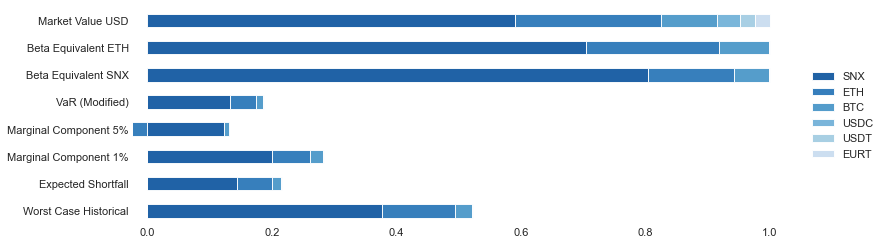

In [98]:
rr.report_portfolio_risk_lenses_snx(betas_table, var_tables_presets)

### Portfolio Correlations & Clustering

Smple visualization to highlight Correlations and Clustering for a 5 day rolling returns with lookback of 60 days.

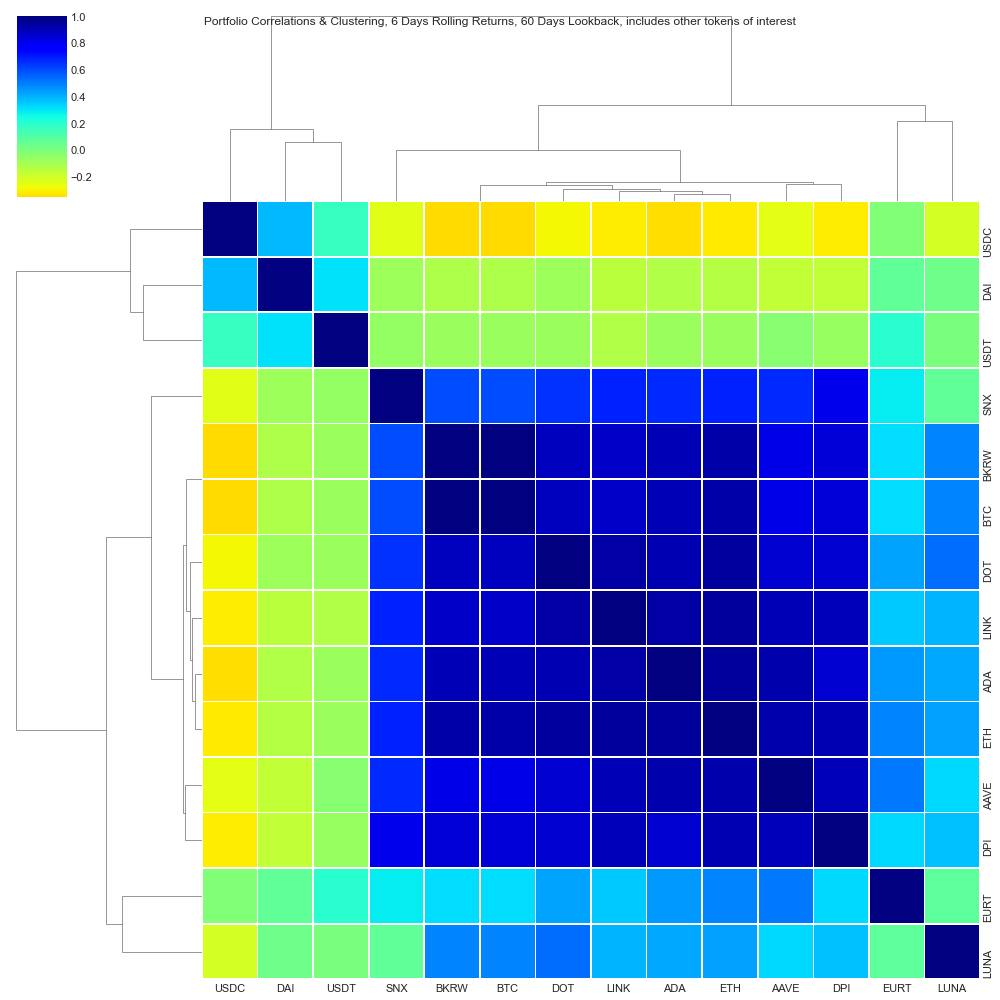

In [99]:
rr.report_correlations(correlations, interval_hold=5, interval_lookback=60, institutional=True)